In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%cd ..

/Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.utils.helpers import load_nifti, save_nifti, calculate_dice_score
from src.utils.sliding_window import extract_windows, merge_windows
from src.segmentation.fusion_methods import majority_vote, staple_fusion, probability_fusion
from src.evaluation.metrics import compute_dice_coefficient
from src.segmentation.label_fusion_pipeline import LabelFusionPipeline

In [4]:
atlas_path = './Data/transformed_labels/IBSR_11'
fixed_image_path = './Data/Validation_Set/IBSR_11/IBSR_11.nii.gz'
ground_truth_path = './Data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz'

In [5]:
# current_directory = os.getcwd()
# atlas_path = os.path.join(current_directory, 'Data/transformed_labels/IBSR_11')
# fixed_image_path = os.path.join(current_directory,'Data/Validation_Set/IBSR_11/IBSR_11.nii.gz')
# ground_truth_path = os.path.join(current_directory,'Data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz')

In [6]:
fixed_image, fixed_affine = load_nifti(fixed_image_path)
ground_truth, _ = load_nifti(ground_truth_path)

In [7]:
pipeline = LabelFusionPipeline(
    fixed_image=fixed_image,
    transformed_labels_dir = atlas_path
)

In [8]:
fusion_methods = {
    "Majority Voting": majority_vote
}

In [10]:
results = {}
for method_name, fusion_method in fusion_methods.items():
    print(f"Running {method_name}...")
    pipeline.load_transformed_labels()
    pipeline.apply_fusion(fusion_method)
    fused_result = pipeline.fused_label

    # # Save the result
    # output_path = os.path.join(output_dir, f"IBSR_11_{method_name.replace(' ', '_').lower()}.nii.gz")
    # save_nifti(fused_result, fixed_affine, output_path)
    # print(f"Saved result to {output_path}")

    # Evaluate and store metrics
    dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_result)
    results[method_name] = {"Dice": dice_score}


Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.


In [23]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
Majority Voting: Dice = 0.8446
Majority Voting: Dice = {1.0: 0.8295481262049185, 2.0: 0.8575996832809217, 3.0: 0.8465838673877014}


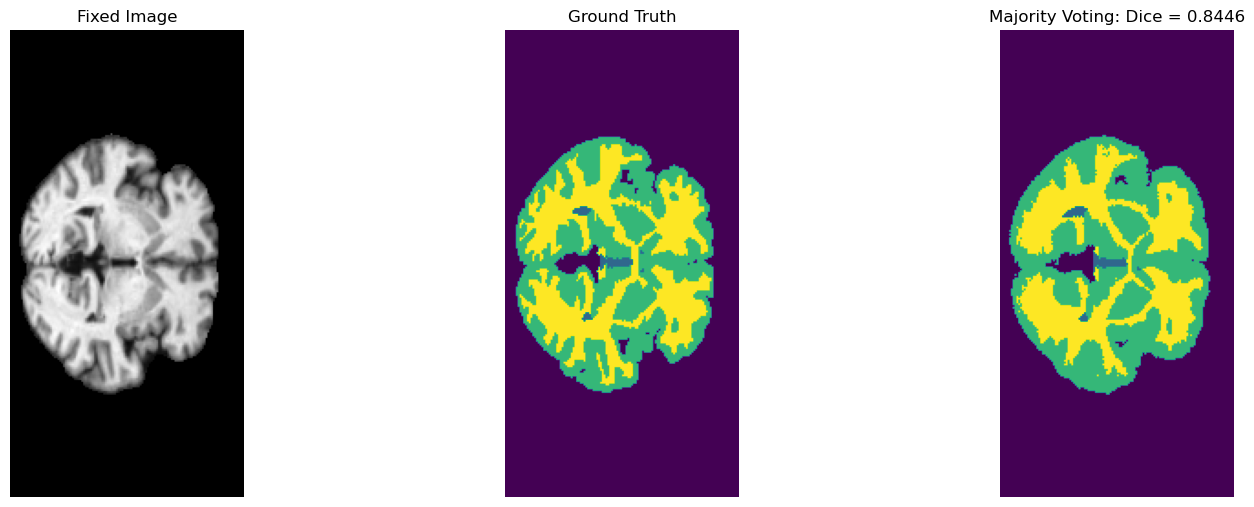

In [21]:
# Visualization
def visualize_results(fixed_image, ground_truth, results, slice_idx):
    """
    Visualize segmentation results on a single slice.
    Parameters:
        fixed_image (np.ndarray): Fixed image.
        ground_truth (np.ndarray): Ground truth segmentation.
        results (dict): Dictionary of segmentation results.
        slice_idx (int): Index of the slice to visualize.
    """
    plt.figure(figsize=(15, 10))

    # Fixed image
    plt.subplot(2, 3, 1)
    plt.imshow(fixed_image[:, :, slice_idx], cmap="gray")
    plt.title("Fixed Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(2, 3, 2)
    plt.imshow(ground_truth[:, :, slice_idx], cmap="viridis")
    plt.title("Ground Truth")
    plt.axis("off")

    # Segmentation results
    for i, (method, metrics) in enumerate(results.items(), start=3):
        plt.subplot(2, 3, i)
        plt.imshow(metrics["Fused Result"][:, :, slice_idx], cmap="viridis")
        plt.title(f"{method}: Dice = {(sum(metrics['Dice'].values()) / len(metrics['Dice'])):.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Add fused results to `results` for visualization
for method_name, fusion_method in fusion_methods.items():
    results[method_name]["Fused Result"] = pipeline.fused_label

# Visualize on a middle slice
slice_idx = fixed_image.shape[2] // 2
visualize_results(fixed_image, ground_truth, results, slice_idx)


Processing IBSR_11...
  Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.

Processing IBSR_12...
  Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.

Processing IBSR_13...
  Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.

Processing IBSR_14...
  Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.

Processing IBSR_17...
  Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.

Evaluation Metrics:

IBSR_11:
  Majority Voting: Average Dice = 0.8446
    Label 1.0: Dice = 0.8295
    Label 2.0: Dice = 0.8576
    Label 3.0: Dice = 0.8466

IBSR_12:
  Majority Voting: Average Dice = 0.8361
    Label 1.0: Dice = 0.8080
    Label 2.0: Dice = 0.8550
    Label 3.0: Dice = 0.8452

IBSR_13:
  Majority Voting: Average Dice = 0.8293
    Label 1.0: Dice = 0.7987
    Label 2.0: Dice = 0.8762
    Label 3.0: Dice = 0.8131

IBSR_14:
  Majority Voting: A

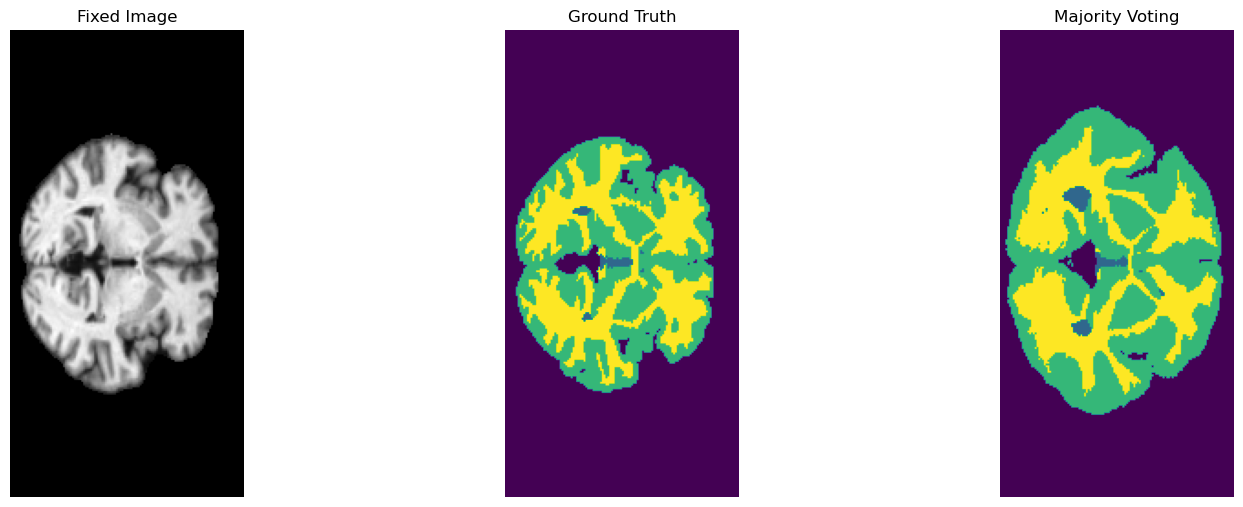

In [25]:
import nibabel as nib


# Directories
validation_dir = './Data/Validation_Set/'
transformed_labels_dir = './Data/transformed_labels/'
results = {}

# Iterate over all validation images
for folder_name in sorted(os.listdir(validation_dir)):
    # Define paths for current validation image
    fixed_image_path = os.path.join(validation_dir, folder_name, f"{folder_name}.nii.gz")
    ground_truth_path = os.path.join(validation_dir, folder_name, f"{folder_name}_seg.nii.gz")
    atlas_path = os.path.join(transformed_labels_dir, folder_name)

    # Check if files exist
    if not os.path.exists(fixed_image_path) or not os.path.exists(ground_truth_path) or not os.path.exists(atlas_path):
        print(f"Skipping {folder_name}: Required files not found.")
        continue

    print(f"\nProcessing {folder_name}...")

    # Load fixed image and ground truth
    fixed_image = nib.load(fixed_image_path).get_fdata()
    ground_truth = nib.load(ground_truth_path).get_fdata()

    # Initialize results for this validation image
    results[folder_name] = {}

    # Process each fusion method
    for method_name, fusion_method in fusion_methods.items():
        print(f"  Running {method_name}...")

        # Load transformed labels
        pipeline = LabelFusionPipeline(fixed_image=fixed_image, transformed_labels_dir=atlas_path)
        pipeline.load_transformed_labels()
        pipeline.apply_fusion(fusion_method)

        # Store fused result and evaluate Dice score
        fused_result = pipeline.fused_label
        dice_scores = calculate_dice_score(np.squeeze(ground_truth), fused_result)  # Returns label-wise Dice

        # Store results
        results[folder_name][method_name] = {
            "Dice": dice_scores,  # Label-wise Dice
            "Average Dice": sum(dice_scores.values()) / len(dice_scores),  # Compute average
        }

# Print evaluation metrics
print("\nEvaluation Metrics:")
for folder_name, folder_results in results.items():
    print(f"\n{folder_name}:")
    for method_name, metrics in folder_results.items():
        print(f"  {method_name}: Average Dice = {metrics['Average Dice']:.4f}")
        for label, dice in metrics["Dice"].items():
            print(f"    Label {label}: Dice = {dice:.4f}")

# Visualization
def visualize_results(fixed_image, ground_truth, fused_results, slice_idx):
    """
    Visualize segmentation results on a single slice.
    Parameters:
        fixed_image (np.ndarray): Fixed image.
        ground_truth (np.ndarray): Ground truth segmentation.
        fused_results (dict): Dictionary of fused results for each method.
        slice_idx (int): Index of the slice to visualize.
    """
    plt.figure(figsize=(15, 10))

    # Fixed image
    plt.subplot(2, len(fused_results) + 2, 1)
    plt.imshow(fixed_image[:, :, slice_idx], cmap="gray")
    plt.title("Fixed Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(2, len(fused_results) + 2, 2)
    plt.imshow(ground_truth[:, :, slice_idx], cmap="viridis")
    plt.title("Ground Truth")
    plt.axis("off")

    # Fused results
    for i, (method_name, fused_result) in enumerate(fused_results.items(), start=3):
        plt.subplot(2, len(fused_results) + 2, i)
        plt.imshow(fused_result[:, :, slice_idx], cmap="viridis")
        plt.title(method_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize one of the validation results
for folder_name in results.keys():
    print(f"\nVisualizing results for {folder_name}...")
    fixed_image = nib.load(os.path.join(validation_dir, folder_name, f"{folder_name}.nii.gz")).get_fdata()
    ground_truth = nib.load(os.path.join(validation_dir, folder_name, f"{folder_name}_seg.nii.gz")).get_fdata()
    fused_results = {method_name: pipeline.fused_label for method_name in fusion_methods.keys()}
    slice_idx = fixed_image.shape[2] // 2
    visualize_results(fixed_image, ground_truth, fused_results, slice_idx)
    break  # Visualize only one validation image for simplicity